In [2]:
import sys
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *

def linear_fit(time,dtheta,tstart,tend):
    ts = which_tID(time,tstart)
    te = which_tID(time,tend)+1
    t_fit = time[ts:te]
    dat_fit = dtheta[ts:te]
    growth_rate,shift = np.polyfit(t_fit, dat_fit, 1) #linear fit
    return t_fit,growth_rate,shift

def smooth_modes(f,nmodes):
    fhat = np.fft.fft(f)
    fhat[nmodes+1:-(nmodes+1):] = 0
    f = np.fft.ifft(fhat)
    return f

def get_bounds(flist_plot,nmodes):
    mat = np.zeros([len(flist_plot),4])
    count = 0

    for fname in flist_plot:
        tID = fname.split('_')[-1]
        tID = tID.split('.dat')[0]
        time = nml.read_time(directory,tID)

        # Get 99% thickness
        utilde = np.fromfile( directory + 'shearlayer_utilde_'+str(tID)+'.dat',dtype=float, count=-1, sep=' ')
        itop,ibot,L99 = get_L99(y,utilde)

    #     # Get centerline as utilde=0
    #     utilde = np.fromfile( directory + 'shearlayer_utilde_'+str(tID)+'.dat',dtype=float, count=-1, sep=' ')
    #     ic = np.argmin(abs(utilde))
    #     yc = y[ic]

        # Get centerline as mean peaks of Rij
        dat = np.fromfile( directory + 'shearlayer_Rij_'+str(tID)+'.dat',dtype=float, count=-1, sep=' ')
        n = np.size(dat)
        nstats=6
        dat = np.reshape(dat,[n/nstats,nstats]) 
        yc = 0
        for i in [0,1,3,5]:
            tmp = get_centerline(y,smooth_modes(dat[:,i],nmodes))
            if abs(tmp)<15: yc+=tmp
            else: print(tID,i,tmp)
        yc /= 4.

        mat[count,0] = yc
        mat[count,1] = y[itop]
        mat[count,2] = y[ibot]
        mat[count,3] = time
        count += 1
    return mat

In [3]:
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr_7/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr_7/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc16/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/'
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr_7/1024x1448x512/'

inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(Ly/2.,-Ly/2.,Ny)

flist = glob.glob(directory+"*Rij*")
flist.sort()
print([f.split('/')[-1] for f in flist])
flist = glob.glob(directory+"*utilde*")
flist.sort()
print([f.split('/')[-1] for f in flist])

# And read growth rates
tlist,dlist,rates = growth_rates(directory+'shearlayer_')

Params for this run:
	Mc = 2.0
	Re = 1000.0
	rr = 7.0
Params for this grid:
	N = 1024x1448x512
	L = 80.0x80.0x40.0
['shearlayer_Rij_0001.dat', 'shearlayer_Rij_0002.dat', 'shearlayer_Rij_0003.dat', 'shearlayer_Rij_0004.dat', 'shearlayer_Rij_0005.dat', 'shearlayer_Rij_0006.dat', 'shearlayer_Rij_0007.dat', 'shearlayer_Rij_0008.dat', 'shearlayer_Rij_0009.dat', 'shearlayer_Rij_0010.dat', 'shearlayer_Rij_0011.dat', 'shearlayer_Rij_0012.dat']
['shearlayer_utilde_0001.dat', 'shearlayer_utilde_0002.dat', 'shearlayer_utilde_0003.dat', 'shearlayer_utilde_0004.dat', 'shearlayer_utilde_0005.dat', 'shearlayer_utilde_0006.dat', 'shearlayer_utilde_0007.dat', 'shearlayer_utilde_0008.dat', 'shearlayer_utilde_0009.dat', 'shearlayer_utilde_0010.dat', 'shearlayer_utilde_0011.dat', 'shearlayer_utilde_0012.dat']


/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr7/1024x1448x512/
Growth upper,lower: 0.0315356920452, 0.0145810189026
Growth center: 0.00928268354557
Net Growth upper,lower: 0.0222530084997, 0.0238637024482


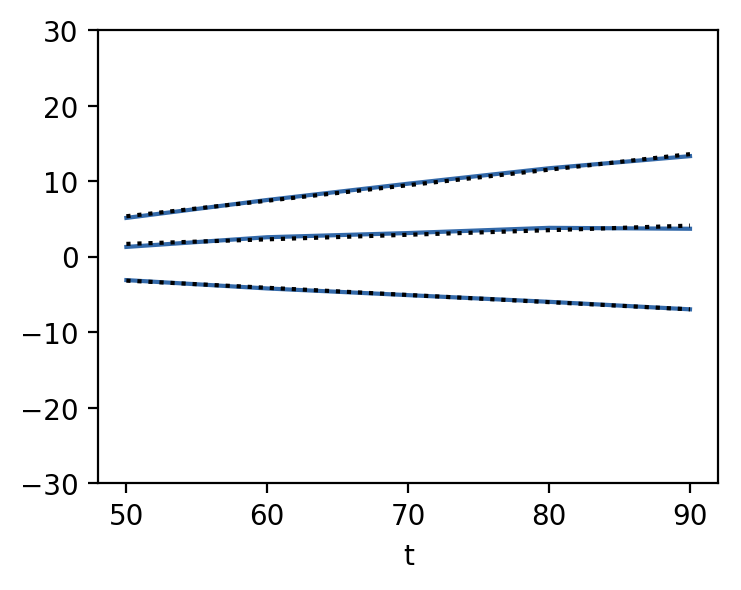

In [474]:
# Get upper, lower bounds and plot around centerline

nmodes = 20 #for smoothing to get centerline
flist_plot = flist[1:]
mat = get_bounds(flist_plot,nmodes)
center = mat[:,0]
upper = mat[:,1]
lower = mat[:,2]
time = mat[:,3]

# fig,ax = plt.subplots(1,2,figsize=(9,3), dpi=100)
# ax[0].plot(time,mat[:,0],'k-',label='center')
# ax[0].plot(time,mat[:,1],'-',label='upper')
# ax[0].plot(time,mat[:,2],'-',label='lower')
# ax[1].plot(time,abs(mat[:,0]-mat[:,1]),'-',label='upper')
# ax[1].plot(time,abs(mat[:,0]-mat[:,2]),'-',label='lower')

# # Clean up plot and save
# ax[0].legend()
# ax[0].grid(True)
# ax[0].set_xlabel('t')
# ax[0].set_ylabel('y')
# ax[0].legend()
# ax[1].grid(True)
# ax[1].set_xlabel('t')
# ax[1].set_ylabel('$y-y_c$')
# plt.savefig(directory+'/img/symmetry.png',dpi=200)

# Make linear fit
ts = 40
te = 1000
color = myblue
ylims = [-30,30]

t_fit,growth_upper,shift_upper = linear_fit(time,upper,ts,te)
t_fit,growth_lower,shift_lower = linear_fit(time,lower,ts,te)
t_fit,growth_center,shift_center = linear_fit(time,center,ts,te)

fig = plt.figure(figsize=(4,3),dpi=200)
plt.plot(time,mat[:,0],'k-',label='center',color=color)
plt.plot(time,mat[:,1],'-',label='upper',color=color)
plt.plot(time,mat[:,2],'-',label='lower',color=color)
plt.plot(time,growth_upper*t_fit+shift_upper,'k:')
plt.plot(time,growth_lower*t_fit+shift_lower,'k:')
plt.plot(time,growth_center*t_fit+shift_center,'k:')

# Make nice
plt.xlabel('t')
plt.ylim(ylims)

du = inp.du
print(directory)
print('Growth upper,lower: {}, {}'.format(abs(growth_upper/du),(abs(growth_lower/du))))
print('Growth center: {}'.format(abs(growth_center/du)))
print('Net Growth upper,lower: {}, {}'.format(abs(growth_upper-growth_center)/du,abs(growth_lower-growth_center)/du))

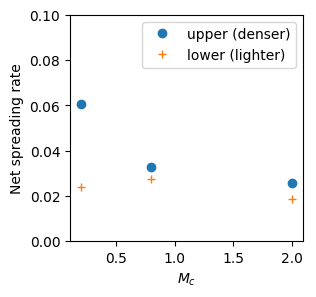

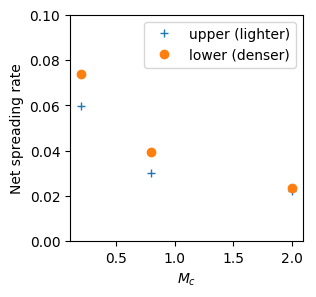

In [479]:
# # Spreading rate
# rate_rr7 = {
#     0.2: [0.0466933057439, 0.0699592625263],
#     0.8: [0.0934044574983, 0.0886223960904],
#     2.0: [0.0313903662754, 0.0142177044781]}
# rate_rr_7 = {
#     0.2: [0.0171754949388, 0.0425830318306], #upper, lower
#     0.8: [0.0149488747588, 0.0451304636705],
#     2.0: [0.0193767693076, 0.0251413581766] }

# # Net spreading rate (utilde centerline)
# rate_rr7 = {
#     0.2: [0.0644630801776, 0.0692315819989],
#     0.8: [0.0353616578518, 0.034415526538],
#     2.0: [0.0209269108503, 0.0246811599033]}
# rate_rr_7 = {
#     0.2: [0.0545202824104, 0.0300861240975], #upper, lower
#     0.8: [0.0285731656782, 0.0315061727511],
#     2.0: [0.023058355476, 0.0214597720081] }

# Net spreading rate (Rij centerline)
rate_rr7 = {
    0.2: [0.0599594951241, 0.0737351670524],
    0.8: [0.0301875022297, 0.0395896821602],
    2.0: [0.022228787538, 0.0233792832156]}
rate_rr_7 = {
    0.2: [0.0608414421376, 0.0237649643703], #upper, lower
    0.8: [0.0326415303277, 0.0274378081015],
    2.0: [0.0257832136599, 0.0187349138243] }

ylims = [0,0.1]

def make_nice():
    plt.legend()
    plt.xlabel('$M_c$')
    plt.ylabel('Net spreading rate')    
    plt.ylim(ylims)

fig1 = plt.figure(figsize=(3,3),dpi=100)
d = rate_rr_7
plt.plot(d.keys(),[v[0] for v in d.values()],'o',label='upper (denser)')
plt.plot(d.keys(),[v[1] for v in d.values()],'+',label='lower (lighter)')
make_nice()

fig2 = plt.figure(figsize=(3,3),dpi=100)
d = rate_rr7
plt.plot(d.keys(),[v[0] for v in d.values()],'+',label='upper (lighter)')
plt.plot(d.keys(),[v[1] for v in d.values()],'o',label='lower (denser)')
make_nice()


(-35, 35)

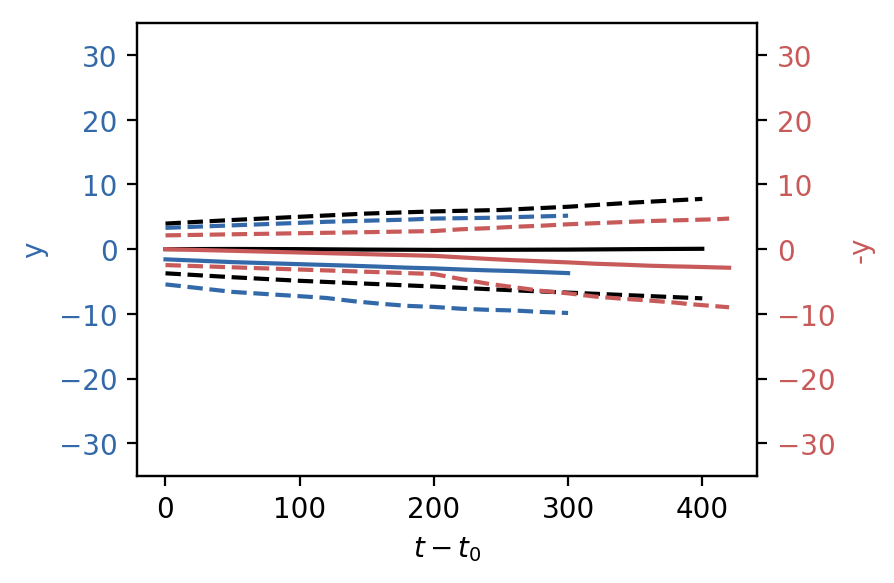

In [476]:
# Compare opposite density ratios, flipped
Mc = '02'
ylims=[-35,35]
nmodes = 6 #for smoothing to get centerline

directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc{}/rr_7/1024x1448x512/'.format(Mc)
flist = glob.glob(directory+"*utilde*")
flist.sort()
flist_plot = flist[::]
mat = get_bounds(flist_plot,nmodes)
time = mat[:,3]-mat[0,3]

fig = plt.figure(figsize=(4,3),dpi=200)
ax = plt.axes()
color=myblue
plt.plot(time,mat[:,0],'-',color=color,label='s=1/7')
plt.plot(time,mat[:,1],'--',color=color)
plt.plot(time,mat[:,2],'--',color=color)
plt.ylabel('y',color=color)
plt.tick_params(axis='y', labelcolor=color)
plt.xlabel('$t-t_0$')
# plt.legend()
plt.ylim(ylims)

directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc{}/rr1/1024x1448x512/'.format(Mc)
flist = glob.glob(directory+"*utilde*")
flist.sort()
flist_plot = flist[::]
mat = get_bounds(flist_plot,nmodes)
time = mat[:,3]-mat[0,3]
color=[0,0,0]
plt.plot(time,mat[:,0],'-',color=color,label='s=1')
plt.plot(time,mat[:,1],'--',color=color)
plt.plot(time,mat[:,2],'--',color=color)

directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc{}/rr7/1024x1448x512/'.format(Mc)
flist = glob.glob(directory+"*utilde*")
flist.sort()
flist_plot = flist[::]
mat = get_bounds(flist_plot,nmodes)
time = mat[:,3]-mat[0,3]

fig2 = ax.twinx()
color = myred
plt.plot(time,-mat[:,0],'-',color=color,label='s=7')
plt.plot(time,-mat[:,1],'r--',color=color)
plt.plot(time,-mat[:,2],'r--',color=color)
plt.ylabel('-y',color=color)
plt.tick_params(axis='y', labelcolor=color)
# plt.legend()
plt.ylim(ylims)



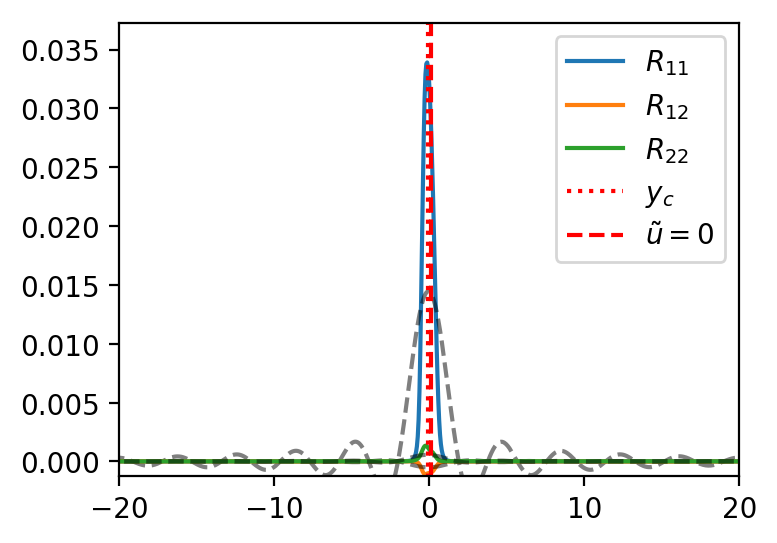

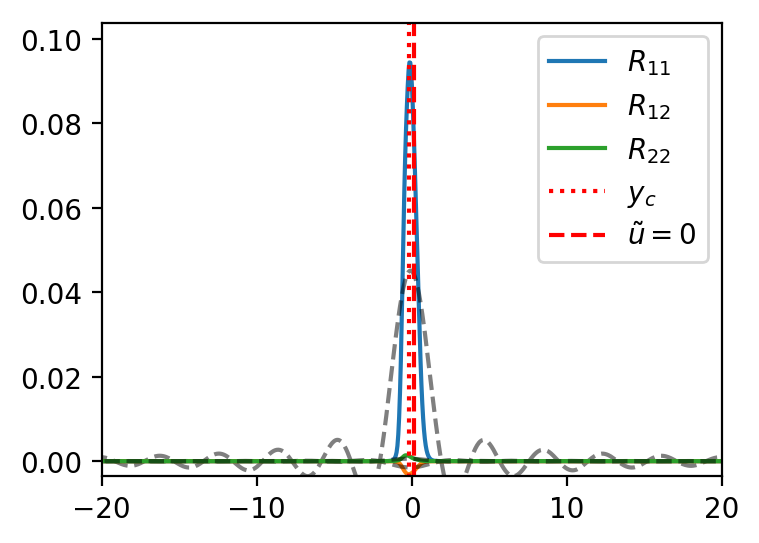

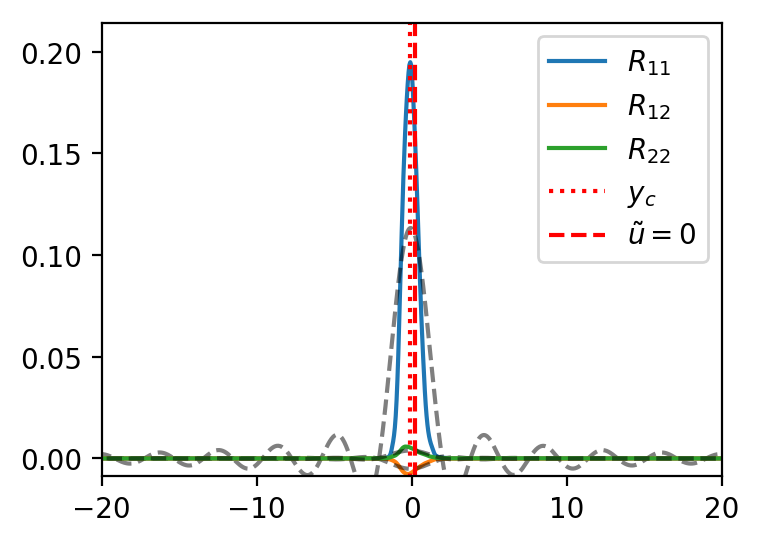

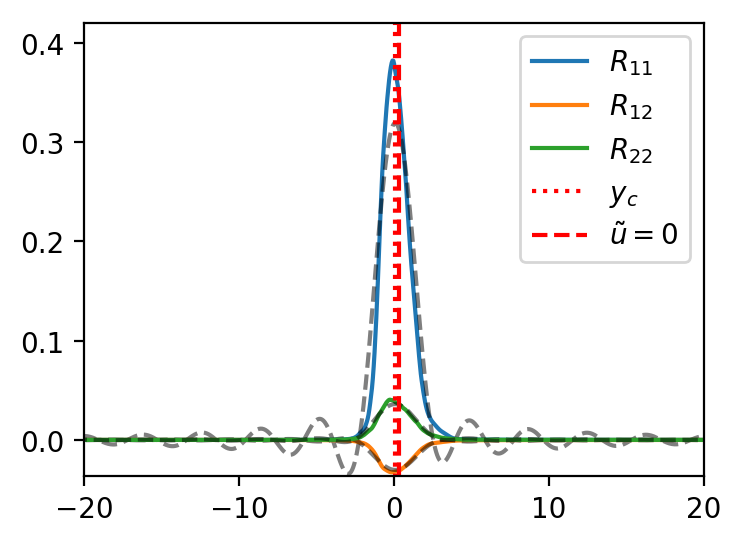

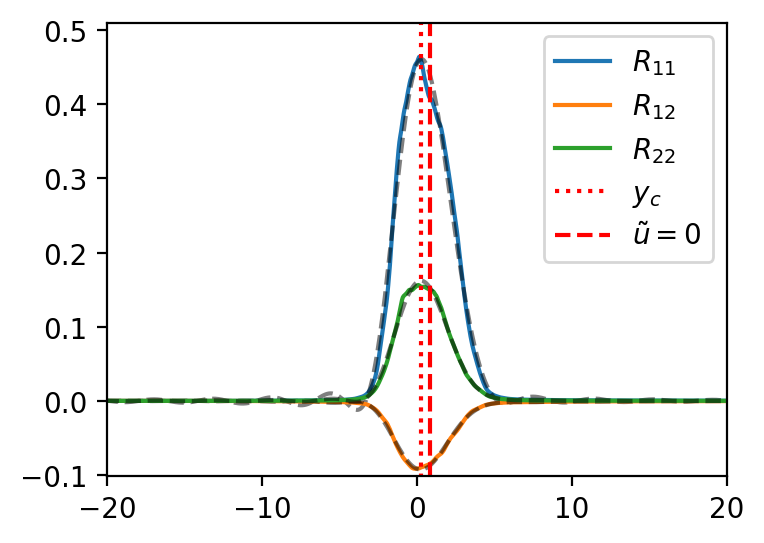

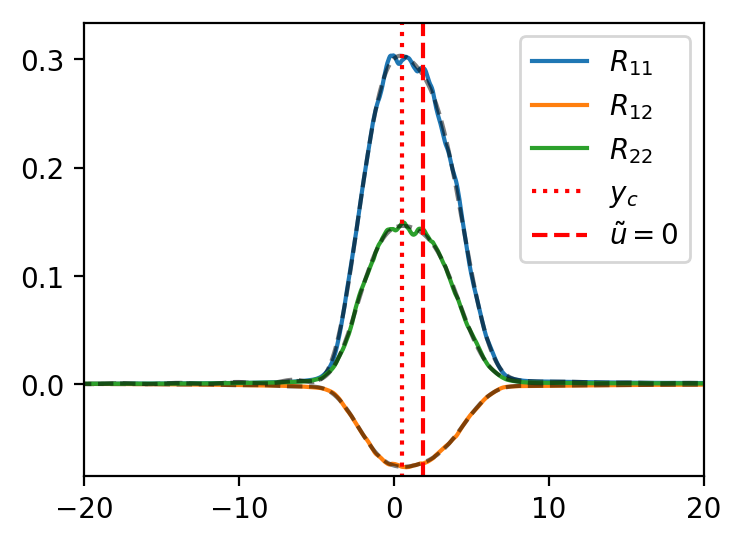

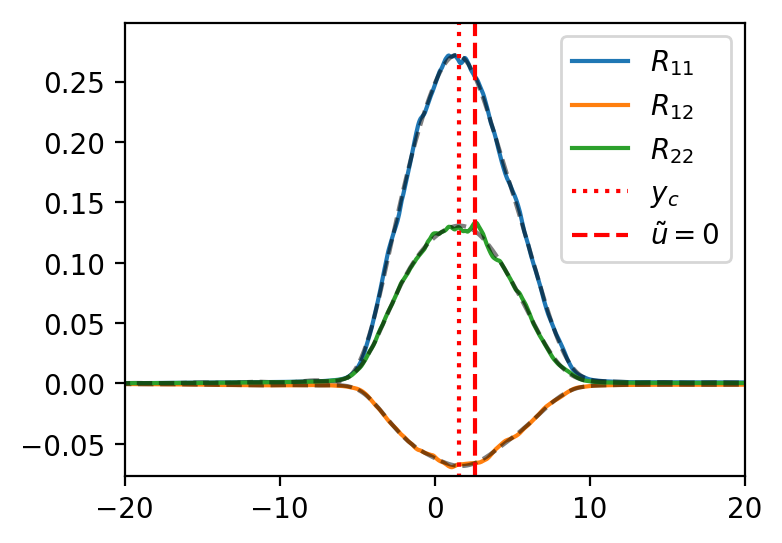

In [10]:
# Plot the stress profiles
labels=['$R_{11}$','$R_{12}$','$R_{22}$','$R_{33}$']

nmodes = 20

for fname in flist[:-5]:
    
    plt.figure(figsize=(4,3),dpi=200)
    
    tID = fname.split('_')[-1]
    tID = tID.split('.dat')[0]
    time = nml.read_time(directory,tID)

    # Get centerline as mean peaks of Rij
    dat = np.fromfile( directory + 'shearlayer_Rij_'+str(tID)+'.dat',dtype=float, count=-1, sep=' ')
    n = np.size(dat)
    nstats=6
    dat = np.reshape(dat,[n/nstats,nstats]) 
    yc = 0
    for i,label in zip([0,1,5],labels):
        ic = np.argmax(smooth_modes(abs(dat[:,i]),nmodes))
        yc += y[ic]
        plt.plot(y,dat[:,i],label=label)
        plt.plot(y,smooth_modes(dat[:,i],nmodes),'k--',alpha=0.5)
    yc /= 3
    plt.ylim([1.1*min(dat[:,1]),1.1*max(dat[:,0])])
    plt.plot([yc,yc],[-1,1],'r:',label=r'$y_c$')
    plt.xlim([-20,20])


    # Get centerline as utilde=0
    utilde = np.fromfile( directory + 'shearlayer_utilde_'+str(tID)+'.dat',dtype=float, count=-1, sep=' ')
    ic = np.argmin(abs(utilde))
    plt.plot([y[ic],y[ic]],[-1,1],'r--',label=r'$\tilde{u}=0$')
    
    plt.legend()
    plt.show()
    
    